## Question 1: Propensity score matching

#### Dataset description

- `treat`: 1 if the subject participated in the job training program, 0 otherwise
- `age`: the subject's age
- `educ`: years of education
- `race`: categorical variable with three possible values: Black, Hispanic, or White
- `married`: 1 if the subject was married at the time of the training program, 0 otherwise
- `nodegree`: 1 if the subject has earned no school degree, 0 otherwise
- `re74`: real earnings in 1974 (pre-treatment)
- `re75`: real earnings in 1975 (pre-treatment)
- `re78`: real earnings in 1978 (outcome)

In [45]:
import os
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import widgets,interact
from IPython.display import display

from sklearn import linear_model


#### 1. A naive analysis

Compare the distribution of the outcome variable (`re78`) between the two groups, using plots and numbers.
To summarize and compare the distributions, you may use the techniques we discussed in lectures 4 ("Read the stats carefully") and 6 ("Data visualization").

What might a naive "researcher" conclude from this superficial analysis?

In [46]:
path = './lalonde.csv'
dataset = pd.read_csv(path)

In [47]:
display(dataset.head(7))

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
0,NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460
1,NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940
2,NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500
3,NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460
4,NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899
5,NSW6,1,22,9,1,0,0,1,0.0,0.0,4056.4940
6,NSW7,1,23,12,1,0,0,0,0.0,0.0,0.0000


In [48]:
copyDS = dataset.copy()
''' 
Here we want to see the distribution of the subject participated in the job training program and the ones that didn't.
We will do two box plot an analyse them.
'''

NSW = dataset.loc[copyDS['treat'] == 1]['re78'] # participated in the job training program
PSID = dataset.loc[copyDS['treat'] == 0]['re78'] # Didn't participated in the job training program

In [49]:
#Quantifing the amount of 0 in the each group
NSWZeros = np.where(NSW == 0.0)[0]
PSIDZeros = np.where(PSID == 0.0)[0]
print(PSID[PSID == 0].index)
print('There are ' + str(len(NSWZeros)) + ' zeros in NSW and ' + str(len(PSIDZeros)) + ' in PSID')
print(PSIDZeros)

Int64Index([189, 193, 208, 211, 214, 230, 255, 259, 261, 268, 271, 272, 273,
            281, 282, 293, 297, 298, 312, 321, 327, 328, 336, 338, 340, 351,
            359, 360, 373, 379, 381, 384, 385, 386, 398, 400, 401, 407, 408,
            412, 420, 422, 423, 426, 428, 429, 430, 433, 440, 442, 456, 459,
            461, 467, 472, 475, 483, 489, 495, 496, 502, 504, 509, 519, 521,
            524, 527, 530, 533, 539, 540, 544, 546, 547, 548, 550, 552, 553,
            557, 558, 566, 567, 571, 574, 576, 579, 586, 588, 589, 592, 596,
            598, 599, 600, 603, 605, 608, 611],
           dtype='int64')
There are 45 zeros in NSW and 98 in PSID
[  4   8  23  26  29  45  70  74  76  83  86  87  88  96  97 108 112 113
 127 136 142 143 151 153 155 166 174 175 188 194 196 199 200 201 213 215
 216 222 223 227 235 237 238 241 243 244 245 248 255 257 271 274 276 282
 287 290 298 304 310 311 317 319 324 334 336 339 342 345 348 354 355 359
 361 362 363 365 367 368 372 373 381 382 386 389 391 3

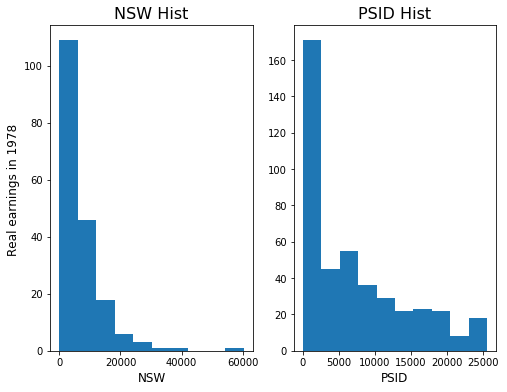

In [50]:
plt.figure(figsize=(8, 6)) 

plt.subplot(1, 2, 1)
histNSW = plt.hist(NSW.tolist())
plt.title('NSW Hist',fontsize=16)
plt.ylabel('Real earnings in 1978 ',fontsize=12)
plt.xlabel('NSW',fontsize=12)

plt.subplot(1, 2, 2)
histPSID = plt.hist(PSID.tolist())
plt.title('PSID Hist',fontsize=16)
plt.xlabel('PSID',fontsize=12)


plt.show()

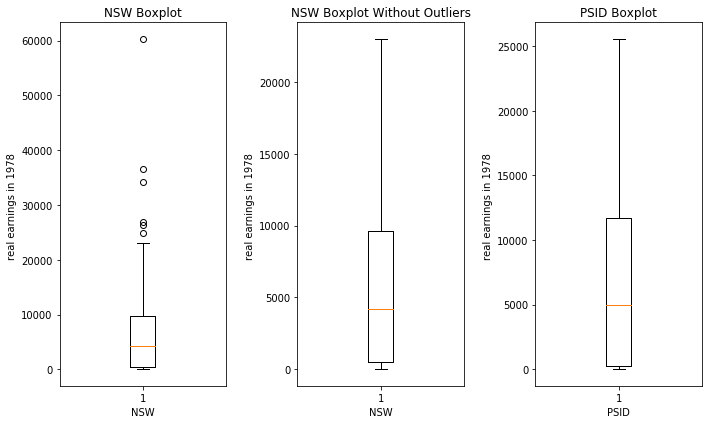

In [51]:
# multiple box plots on one figure
plt.figure(figsize=(10, 6)) 
plt.subplot(131)
plt.boxplot(NSW.tolist())
plt.title('NSW Boxplot')
plt.ylabel('real earnings in 1978 ')
plt.xlabel('NSW')


plt.subplot(132)
plt.boxplot(NSW.tolist(),0,'')
plt.title('NSW Boxplot Without Outliers')
plt.ylabel('real earnings in 1978 ')
plt.xlabel('NSW')


plt.subplot(133)
plt.boxplot(PSID.tolist())
plt.title('PSID Boxplot')
plt.ylabel('real earnings in 1978 ')
plt.xlabel('PSID')


plt.tight_layout()
plt.show()

At first sight, we could say that both histograms and  box plot are very similar. The only difference is that the NSW data have some outliers. However, it's highly possible that those outliers play an important role. As seen in the lecture, some distributions are all about the “outliers”.

As we are interested in the outcome we will only keep subject with an income in 1978, which means that we will skip the people that didn't have an outcome for the resting of the homework.

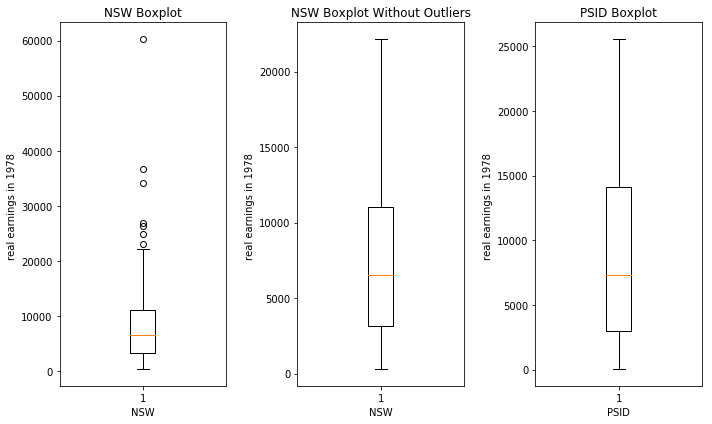

In [52]:
NSWOutcome = NSW.drop(NSWZeros)
PSIDOutcome = PSID.drop(PSID[PSID == 0].index)


# multiple box plots on one figure
plt.figure(figsize=(10, 6)) 
plt.subplot(131)
plt.boxplot(NSWOutcome.tolist())
plt.title('NSW Boxplot')
plt.ylabel('real earnings in 1978 ')
plt.xlabel('NSW')


plt.subplot(132)
plt.boxplot(NSWOutcome.tolist(),0,'')
plt.title('NSW Boxplot Without Outliers')
plt.ylabel('real earnings in 1978 ')
plt.xlabel('NSW')


plt.subplot(133)
plt.boxplot(PSIDOutcome.tolist())
plt.title('PSID Boxplot')
plt.ylabel('real earnings in 1978 ')
plt.xlabel('PSID')


plt.tight_layout()
plt.show()

We can see for the PSID Boxplot and the NSW boxplot without outliers, that the median increased considerably while skipping the people without income in 1978. Indeed the median is almost 7500 of earning while the median if we count the people without income is over 5000 of earnings.


#### 2. A closer look at the data

You're not naive, of course (and even if you are, you've learned certain things in ADA), so you aren't content with a superficial analysis such as the above.
You're aware of the dangers of observational studies, so you take a closer look at the data before jumping to conclusions.

For each feature in the dataset, compare its distribution in the treated group with its distribution in the control group, using plots and numbers.
As above, you may use the techniques we discussed in class for summarizing and comparing the distributions.

What do you observe?
Describe what your observations mean for the conclusions drawn by the naive "researcher" from his superficial analysis.

In [53]:
#Selecting Black people that follow the training or not
blackNSW = dataset.loc[copyDS['treat'] == 1]['black'] 
blackPSID = dataset.loc[copyDS['treat'] == 0]['black'] 

#Selecting Hispanic people that follow the training or not
hispanNSW = dataset.loc[copyDS['treat'] == 1]['hispan'] 
hispanPSID = dataset.loc[copyDS['treat'] == 0]['hispan']

#Selecting married people that follow the training or not
marriedNSW = dataset.loc[copyDS['treat'] == 1]['married'] 
marriedPSID = dataset.loc[copyDS['treat'] == 0]['married']

In [54]:
#Percentage of black people in that followed the training
blackNSWPer = round(blackNSW[blackNSW == 1].size / blackNSW.size * 100)
#Percentage of black people in that didn't followed the training
blackPSIDPer = round(blackPSID[blackPSID == 1].size / blackPSID.size * 100)

#Percentage of hispanic people in that followed the training
hispanNSWPer = round(hispanNSW[hispanNSW == 1].size / hispanNSW.size * 100)
#Percentage of hispanic people in that didn't followed the training
hispanPSIDPer = round(hispanPSID[hispanPSID == 1].size / hispanPSID.size * 100)

#Percentage of married people in that followed the training
marriedNSWPer = round(marriedNSW[marriedNSW == 1].size / marriedNSW.size * 100)
#Percentage of married people in that didn't followed the training
marriedPSIDPer = round(marriedPSID[marriedPSID == 1].size / marriedPSID.size * 100)





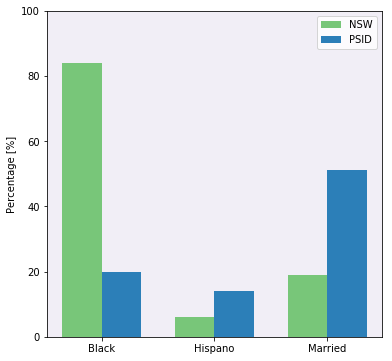

In [55]:
import numpy as np
import matplotlib.pyplot as plt


N = 3
NSWBar = (blackNSWPer, hispanNSWPer, marriedNSWPer)
PSIDBar = (blackPSIDPer, hispanPSIDPer, marriedPSIDPer)

ind = np.arange(N)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots()
fig.set_figheight(6)
rects1 = ax.bar(ind, NSWBar, width, color='#78c679')

rects2 = ax.bar(ind + width, PSIDBar, width, color='#2c7fb8')

# add some text for labels, title and axes ticks
ax.set_facecolor('#f1eef6')
ax.set_ylabel('Percentage [%]')
ax.set_ylim(0, 100)
#ax.set_title('Percentage ')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(('Black', 'Hispano', 'Married'))

ax.legend((rects1[0], rects2[0]), ('NSW', 'PSID'))


plt.show()

In [56]:
dataset['id'].loc[dataset['treat'] == 1] = 'NSW'
dataset['id'].loc[dataset['treat'] == 0] = 'PSID'
dataset.rename(columns={'id':'Treatment'}, inplace=True)

/usr/local/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


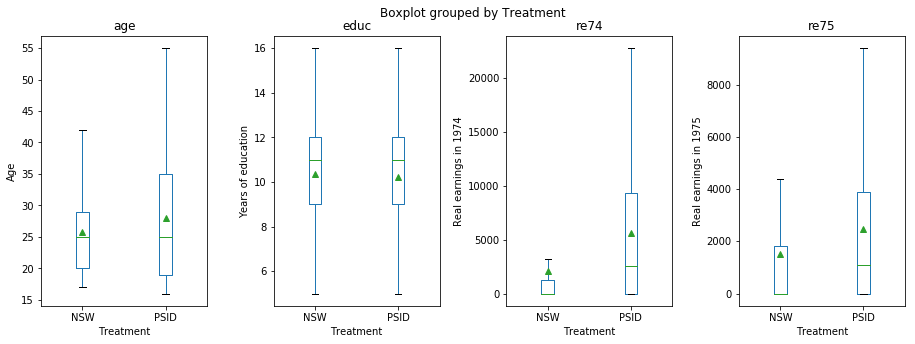

In [57]:
#dataset['id'].loc[dataset['treat'] == 1] = 'NSW'
#dataset['id'].loc[dataset['treat'] == 0] = 'PSID'
#dataset.rename(columns={'id':'Treatment'}, inplace=True)
#Making plots
fig, axs = plt.subplots(1,4,gridspec_kw =  dict(wspace=0.4), figsize=(15,5))
fig.subplots_adjust(wspace=1)
#fig.suptitle('New title here')

fig.texts = [] #flush the old super titles
axs[0].get_figure().suptitle("")
#plt.suptitle('Some title')

axs[0].set_ylabel('Age')
axs[1].set_ylabel('Years of education')
axs[2].set_ylabel('Real earnings in 1974')
axs[3].set_ylabel('Real earnings in 1975')


dataset.boxplot(column='age',  by='Treatment', ax=axs[0],grid = False, showfliers=False, showmeans=True)
dataset.boxplot(column='educ', by='Treatment', ax=axs[1],grid = False, showfliers=False, showmeans=True)
dataset.boxplot(column='re74', by='Treatment', ax=axs[2],grid = False, showfliers=False, showmeans=True)
dataset.boxplot(column='re75', by='Treatment', ax=axs[3],grid = False, showfliers=False, showmeans=True)
plt.show()

#### 3. A propensity score model

Use logistic regression to estimate propensity scores for all points in the dataset.
You may use `sklearn` to fit the logistic regression model and apply it to each data point to obtain propensity scores:

```python
from sklearn import linear_model
logistic = linear_model.LogisticRegression()
```

Recall that the propensity score of a data point represents its probability of receiving the treatment, based on its pre-treatment features (in this case, age, education, pre-treatment income, etc.).
To brush up on propensity scores, you may read chapter 3.3 of the above-cited book by Rosenbaum or [this article](https://drive.google.com/file/d/0B4jctQY-uqhzTlpBaTBJRTJFVFE/view).

Note: you do not need a train/test split here. Train and apply the model on the entire dataset. If you're wondering why this is the right thing to do in this situation, recall that the propensity score model is not used in order to make predictions about unseen data. Its sole purpose is to balance the dataset across treatment groups.
(See p. 74 of Rosenbaum's book for an explanation why slight overfitting is even good for propensity scores.
If you want even more information, read [this article](https://drive.google.com/file/d/0B4jctQY-uqhzTlpBaTBJRTJFVFE/view).)

Object `PropensityScore.cols` not found.


In [78]:
path = './lalonde.csv'
propensySet = pd.read_csv(path)


logistic = linear_model.LogisticRegression()


X = propensySet[['age','educ','hispan','married','nodegree','re74','re75','re78']]  # we only take the first two features.
Y = propensySet['treat']

# we create an instance of Neighbours Classifier and fit the data.
logistic.fit(X, Y)
# The returned estimates for all classes are ordered by the label of classes.
PropensityScore = pd.DataFrame(logistic.predict_proba(X))

PropensityScore.columns = ['prop score no PSID', 'prop score no NSW']
PropensityScore['Treat'] = propensySet['treat']
display(PropensityScore)


,prop score no PSID,prop score no NSW,Treat
0,0.630497,0.369503,1
1,0.586747,0.413253,1
2,0.574398,0.425602,1
3,0.599199,0.400801,1
4,0.632283,0.367717,1
5,0.585671,0.414329,1
6,0.601518,0.398482,1
7,0.615371,0.384629,1
8,0.598110,0.401890,1
9,0.612119,0.387881,1


#### 4. Balancing the dataset via matching

#### 5. Balancing the groups further

#### 6. A less naive analysis

## Question 2: Applied ML